In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from ldaSingleCell import VariationalLDA
from scipy import spatial
from scipy.stats import binom
from statsmodels.stats.multitest import multipletests
from utilsFuncs import *
import re

In [2]:
metaData = pd.read_csv("/data/Alex/PIC_seq_data/GSE135382_metadata2.txt",sep="\t")

In [3]:
metaData.head()

well amplifaction_batch sequencing_batch    tissue sorting_scheme  \
0  WMC1016609             AB6032            SB304  in vitro   TCRb+ CD11c+   
1  WMC1016610             AB6032            SB304  in vitro   TCRb+ CD11c+   
2  WMC1016611             AB6032            SB304  in vitro   TCRb+ CD11c+   
3  WMC1016612             AB6032            SB304  in vitro   TCRb+ CD11c+   
4  WMC1016613             AB6032            SB304  in vitro   TCRb+ CD11c+   

    treatment timepoint  replicate well_coordinates Pool_barcode Cell_barcode  \
0  Co-culture       20h          2               A1     GATGCTCA      CTATTCG   
1  Co-culture       20h          2               C1     GATGCTCA      ACTCAGG   
2  Co-culture       20h          2               E1     GATGCTCA      ACACGTG   
3  Co-culture       20h          2               G1     GATGCTCA      TCTTCGA   
4  Co-culture       20h          2               I1     GATGCTCA      AGCACTG   

   Number_of_cells  
0                1  
1                1  
2                1  
3                1  
4                1

Cells to use: 

* 3h,20h,48h DCs (mono-culture)
* 3h, 20h, 48h T cells (mono-culture)
* 3h,20h, 48h co-culture: DCs, T-cells, and PICs


In [4]:
files_tcells = np.unique(metaData[(metaData['sorting_scheme']=='TCRb+')
                   & (metaData['treatment']=='Co-culture') & (metaData['timepoint'].isin(["3h","20h","48h"]))]['amplifaction_batch'])

files_tcells

array(['AB6034', 'AB6196', 'AB6208', 'AB6209', 'AB6210', 'AB6214',
       'AB6218', 'AB6219'], dtype=object)

In [5]:
files_tcells

array(['AB6034', 'AB6196', 'AB6208', 'AB6209', 'AB6210', 'AB6214',
       'AB6218', 'AB6219'], dtype=object)

In [6]:
#creating a merged matrix of all DCs: 
files_dcs = np.unique(metaData[(metaData['sorting_scheme']=='CD11c+')
                   & (metaData['treatment']=='Co-culture') & (metaData['timepoint'].isin(["3h","20h","48h"]))]['amplifaction_batch'])

files_dcs

array(['AB6035', 'AB6036', 'AB6194', 'AB6195', 'AB6203', 'AB6204',
       'AB6207', 'AB6217'], dtype=object)

In [7]:
pics = np.unique(metaData[(metaData['sorting_scheme']=='TCRb+ CD11c+')
                   & (metaData['treatment']=='Co-culture') & (metaData['timepoint'].isin(["3h","20h","48h"]))]['amplifaction_batch'])

pics

array(['AB6032', 'AB6033', 'AB6192', 'AB6193', 'AB6201', 'AB6202',
       'AB6205', 'AB6206', 'AB6215', 'AB6216'], dtype=object)

In [8]:
def concatData(fileIds):
    path = "/data/Alex/PIC_seq_data/"
    files = []
    for a in fileIds: 
        filename = glob.glob(path+"*_" +a+ ".txt")
        files.append(filename[0])
    df_from_each_file = (pd.read_csv(f,sep='\t',index_col=0) for f in files)
    concatenated_df   = pd.concat(df_from_each_file, axis=1)
    return concatenated_df

In [9]:
dcs = concatData(files_dcs)

In [10]:
tcells = concatData(files_tcells)

In [11]:
print (dcs.shape)

print (tcells.shape)


(52634, 3072)
(52634, 3072)


In [12]:
picsCells = concatData(pics)

In [13]:
all_cells = pd.concat([dcs,tcells,picsCells],axis = 1)

In [14]:
all_cells.shape

(52634, 9984)

In [15]:
all_cells[all_cells.astype(bool).sum(axis=1)>200]

WMC1017761  WMC1017762  WMC1017763  WMC1017764  WMC1017765  \
0610009B22Rik           0           0           0           0           0   
0610009O20Rik           0           0           0           0           0   
0610010F05Rik           0           0           0           0           0   
0610010K14Rik           0           0           0           0           0   
0610012G03Rik           0           0           0           0           0   
...                   ...         ...         ...         ...         ...   
mt-Tp                   0           1           0           0           0   
mt-Tq                   0           0           0           0           0   
mt-Tt                   0           1           1           1           3   
mt-Tw                   0           0           0           0           0   
mt-Ty                   0           0           0           0           0   

               WMC1017766  WMC1017767  WMC1017768  WMC1017769  WMC1017770  \
0610009B22Rik           0           0           0           0           0   
0610009O20Rik           0           0           0           0           0   
0610010F05Rik           0           0           0           0           0   
0610010K14Rik           0           0           0           0           0   
0610012G03Rik           0           0           1           0           0   
...                   ...         ...         ...         ...         ...   
mt-Tp                   1           0           0           0           0   
mt-Tq                   0           0           0           0           0   
mt-Tt                   1           0           0           3           5   
mt-Tw                   0           0           0           0           1   
mt-Ty                   0           0           0           0           0   

               ...  WMC1087639  WMC1087640  WMC1087641  WMC1087642  \
0610009B22Rik  ...           0           0           0           0   
0610009O20Rik  ...           0           0           0           0   
0610010F05Rik  ...           0           0           0           0   
0610010K14Rik  ...           0           3           0           0   
0610012G03Rik  ...           0           0           0           1   
...            ...         ...         ...         ...         ...   
mt-Tp          ...           0           5           0           4   
mt-Tq          ...           0           0           0           1   
mt-Tt          ...           0          11           6          19   
mt-Tw          ...           0           2           0           3   
mt-Ty          ...           0           0           0           0   

               WMC1087643  WMC1087644  WMC1087645  WMC1087646  WMC1087647  \
0610009B22Rik           0           0           0           0           0   
0610009O20Rik           0           0           0           1           0   
0610010F05Rik           0           0           0           0           0   
0610010K14Rik           0           0           0           0           0   
0610012G03Rik           0           0           0           1           1   
...                   ...         ...         ...         ...         ...   
mt-Tp                   0           0           0           0           0   
mt-Tq                   0           0           0           0           1   
mt-Tt                   7           5           3          12          26   
mt-Tw                   0           0           0           0           2   
mt-Ty                   0           0           0           0           0   

               WMC1087648  
0610009B22Rik           0  
0610009O20Rik           0  
0610010F05Rik           0  
0610010K14Rik           0  
0610012G03Rik           2  
...                   ...  
mt-Tp                   0  
mt-Tq                   0  
mt-Tt                  13  
mt-Tw                   3  
mt-Ty                   0  

[9044 rows x 9984 columns]

In [16]:
all_mono = pd.concat([dcs,tcells],axis=1)

In [17]:
all_mono.shape

(52634, 6144)

In [18]:
tcells = tcells.loc[all_cells[all_cells.astype(bool).sum(axis=1)>200].index]
dcs = dcs.loc[all_cells[all_cells.astype(bool).sum(axis=1)>200].index]

In [19]:
all_mono = all_mono.loc[all_cells[all_cells.astype(bool).sum(axis=1)>200].index]

In [21]:
all_mono = all_mono.T[all_mono.sum(axis=0)>500].T

In [22]:
tcells = tcells.T[tcells.sum(axis=0)>500].T

In [23]:
dcs = dcs.T[dcs.sum(axis=0)>500].T

In [24]:
all_mono.shape

(9044, 4762)

In [25]:
picsCells = picsCells.loc[all_cells[all_cells.astype(bool).sum(axis=1)>200].index]

In [26]:
picsCells = picsCells.T[picsCells.sum(axis=0)>500].T

In [27]:
p = re.compile("Rps|Rpl|Rp")
picsCells = picsCells.drop(list(filter(p.match,picsCells.index.values)),axis=0)
all_mono = all_mono.drop(list(filter(p.match,all_mono.index.values)),axis=0)

In [28]:
singleCellLDA = VariationalLDA(K = 10,alpha = 1,eta=0.005,update_alpha=True)

In [29]:
singleCellLDA.load_data_sc(all_mono)

Edited


In [ ]:
singleCellLDA.run_vb(n_its = 500,initialise=True)

Initialising
Starting iterations


/home1/2064240p/LDA_paper/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 17.8904139720401) (129.41014162500002 seconds, I think I'll finish in 1078.4178468750001 minutes). Alpha: (13.014476251623016,29.68425702456683)
Iteration 1 (change = 0.020847759610947526) (125.13768725 seconds, I think I'll finish in 1040.7284322958333 minutes). Alpha: (15.953589820553805,36.48094509438538)
Iteration 2 (change = 0.02013441048766782) (123.12337490499993 seconds, I think I'll finish in 1021.9240117114994 minutes). Alpha: (16.819716541324386,38.429296390242875)
Iteration 3 (change = 0.019827272831334043) (124.42289244200003 seconds, I think I'll finish in 1030.636292394567 minutes). Alpha: (17.040215773918902,38.893320412578994)
Iteration 4 (change = 0.019451101790063385) (123.43043771399994 seconds, I think I'll finish in 1020.3582851023996 minutes). Alpha: (17.068394401930615,38.91949899870812)
Iteration 5 (change = 0.019361283031796104) (125.45829772799993 seconds, I think I'll finish in 1035.0309562559994 minutes). Alpha: (17.041646435203337,38.

In [36]:
betas_learned = pd.DataFrame(singleCellLDA.beta_matrix)
topic_dict = betas_learned.to_dict(orient='index')

In [37]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,topic_index=singleCellLDA.topic_index,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.005,update_alpha=True, fixed_topics=topic_dict)

Object created with 4762 documents


In [38]:
singleCellLDA.beta_matrix.shape

(10, 8838)

In [39]:
scLDA.load_data_sc(picsCells)

Edited


In [38]:
picsCells.columns

Index(['WMC1016610', 'WMC1016611', 'WMC1016612', 'WMC1016613', 'WMC1016614',
       'WMC1016615', 'WMC1016617', 'WMC1016618', 'WMC1016619', 'WMC1016620',
       ...
       'WMC1087639', 'WMC1087640', 'WMC1087641', 'WMC1087642', 'WMC1087643',
       'WMC1087644', 'WMC1087645', 'WMC1087646', 'WMC1087647', 'WMC1087648'],
      dtype='object', length=3432)

In [40]:
len(scLDA.corpus.keys())

3432

In [41]:
scLDA.run_vb(n_its=500,initialise=True)

Initialising
Here
Starting iterations
Iteration 0 (change = 21.643873694794433) (139.36636076300056 seconds, I think I'll finish in 1161.3863396916713 minutes). Alpha: (2.3115514322340736,31.440763954590963)
Iteration 1 (change = 3.619582317956045) (129.36826075999852 seconds, I think I'll finish in 1075.912701987321 minutes). Alpha: (1.1920931726403237,20.555092207537594)
Iteration 2 (change = 2.240021620834704) (129.52680687500106 seconds, I think I'll finish in 1075.0724970625088 minutes). Alpha: (0.7863665758140205,14.352347313445305)
Iteration 3 (change = 1.6864575188543642) (133.18682519799768 seconds, I think I'll finish in 1103.2308687234142 minutes). Alpha: (0.6043926941481158,10.991423995402016)
Iteration 4 (change = 1.4013476491649426) (132.85911665599997 seconds, I think I'll finish in 1098.302031022933 minutes). Alpha: (0.503703721370814,8.971580056483111)
Iteration 5 (change = 1.233454640995593) (130.6554416020008 seconds, I think I'll finish in 1077.9073932165065 minutes

Iteration 48 (change = 0.7729299543541206) (122.77708017799887 seconds, I think I'll finish in 924.9206706742582 minutes). Alpha: (0.017875648537876376,1.851583056312733)
Iteration 49 (change = 0.763345309597046) (136.06545580300735 seconds, I think I'll finish in 1022.758676119272 minutes). Alpha: (0.017122159656170782,1.8353321436830858)
Iteration 50 (change = 0.7519718258809547) (134.89551102700352 seconds, I think I'll finish in 1011.7163327025264 minutes). Alpha: (0.01643585428147809,1.819564366041688)
Iteration 51 (change = 0.7395440807677316) (133.90768950199708 seconds, I think I'll finish in 1002.0758764399449 minutes). Alpha: (0.0158118241359854,1.8044117666832273)
Iteration 52 (change = 0.7263774951984477) (133.24841460600146 seconds, I think I'll finish in 994.9214957248109 minutes). Alpha: (0.015235173347441606,1.7898600785241237)
Iteration 53 (change = 0.7123899251342195) (133.89322579000145 seconds, I think I'll finish in 997.5045321355108 minutes). Alpha: (0.01471696828

Iteration 96 (change = 0.35619212897724445) (133.80511771900638 seconds, I think I'll finish in 900.9544593079762 minutes). Alpha: (0.00785576902035674,1.3320083831900962)
Iteration 97 (change = 0.35033322215988527) (120.97433187199931 seconds, I think I'll finish in 812.5442624069287 minutes). Alpha: (0.007808550891845155,1.324574753776443)
Iteration 98 (change = 0.3444693035503244) (133.93099927499134 seconds, I think I'll finish in 897.3376951424419 minutes). Alpha: (0.007761318321726928,1.3172257619336285)
Iteration 99 (change = 0.338707163895341) (134.98932367500674 seconds, I think I'll finish in 902.1786465612951 minutes). Alpha: (0.007714008722482678,1.3099378951902556)
Iteration 100 (change = 0.332986880826395) (130.1389054829924 seconds, I think I'll finish in 867.5927032199494 minutes). Alpha: (0.007668638541730265,1.3027128656031073)
Iteration 101 (change = 0.32723563607450185) (134.1666735129984 seconds, I think I'll finish in 892.2083788614393 minutes). Alpha: (0.00762513

Iteration 144 (change = 0.13017443047688793) (132.24694302100397 seconds, I think I'll finish in 784.665195257957 minutes). Alpha: (0.006650010161835244,1.0757128890979901)
Iteration 145 (change = 0.1280360311896404) (130.96565190399997 seconds, I think I'll finish in 774.8801070986665 minutes). Alpha: (0.00663891891010589,1.072851786151563)
Iteration 146 (change = 0.1259613541325244) (132.1147165959992 seconds, I think I'll finish in 779.4768279163952 minutes). Alpha: (0.006628091624637119,1.0700088815221076)
Iteration 147 (change = 0.1239445369115829) (129.81087288699928 seconds, I think I'll finish in 763.7206354851791 minutes). Alpha: (0.006617518025684579,1.0671858443026476)
Iteration 148 (change = 0.12198891823462997) (133.07697223700234 seconds, I think I'll finish in 780.718237123747 minutes). Alpha: (0.0066071874800768165,1.0643700969797318)
Iteration 149 (change = 0.12011633431900001) (134.20709794999857 seconds, I think I'll finish in 785.1115230074917 minutes). Alpha: (0.00

Iteration 192 (change = 0.067940345870054) (132.41585631099588 seconds, I think I'll finish in 679.7347290631121 minutes). Alpha: (0.006277537843404149,0.955594929595545)
Iteration 193 (change = 0.06716490461176776) (131.17897625600745 seconds, I think I'll finish in 671.1990951765714 minutes). Alpha: (0.006271338074310567,0.9533142196482465)
Iteration 194 (change = 0.06640832649530636) (123.30531230098859 seconds, I think I'll finish in 628.8570927350418 minutes). Alpha: (0.006265222849291417,0.9510354909720081)
Iteration 195 (change = 0.06567200710097601) (115.09056201500061 seconds, I think I'll finish in 585.0436902429198 minutes). Alpha: (0.006259188238122769,0.9487615277973055)
Iteration 196 (change = 0.06495856168176727) (130.36063733900664 seconds, I think I'll finish in 660.493895850967 minutes). Alpha: (0.0062532296153642,0.946490059748673)
Iteration 197 (change = 0.06426433381064182) (132.26766771799885 seconds, I think I'll finish in 667.9517219758942 minutes). Alpha: (0.00

Iteration 240 (change = 0.04201755733754182) (134.93134668900166 seconds, I think I'll finish in 584.7025023190072 minutes). Alpha: (0.00597293409150812,0.853104450254056)
Iteration 241 (change = 0.041570312230693546) (135.32607388800534 seconds, I think I'll finish in 584.157552283223 minutes). Alpha: (0.005968228955397871,0.851324995867343)
Iteration 242 (change = 0.04112668798961281) (132.86969334799505 seconds, I think I'll finish in 571.3396813963788 minutes). Alpha: (0.005963583707683397,0.8495746338150754)
Iteration 243 (change = 0.04068690006359591) (136.19985675399948 seconds, I think I'll finish in 583.3893864296311 minutes). Alpha: (0.005958994188566883,0.8478522627082848)
Iteration 244 (change = 0.04025161089078857) (132.00549404000049 seconds, I think I'll finish in 563.2234412373354 minutes). Alpha: (0.005954448688571044,0.846153421122063)
Iteration 245 (change = 0.03982118353280908) (134.12476805399638 seconds, I think I'll finish in 570.0302642294846 minutes). Alpha: (0

Iteration 288 (change = 0.026030356329712838) (131.9054175689962 seconds, I think I'll finish in 466.0658087437866 minutes). Alpha: (0.005730080828922723,0.7865281227524247)
Iteration 289 (change = 0.025788748232012382) (134.74270898199757 seconds, I think I'll finish in 473.8451932533581 minutes). Alpha: (0.00572644765401195,0.7854081129573368)
Iteration 290 (change = 0.025549804392001448) (132.80629537100322 seconds, I think I'll finish in 464.82203379851126 minutes). Alpha: (0.005722868117254229,0.7843052368776078)
Iteration 291 (change = 0.02531354538404873) (136.52457068499643 seconds, I think I'll finish in 475.5605878860709 minutes). Alpha: (0.00571934161981565,0.7832228977928269)
Iteration 292 (change = 0.02508034089223999) (133.32856735501264 seconds, I think I'll finish in 462.20570016404383 minutes). Alpha: (0.005715867168765993,0.7821556503334813)
Iteration 293 (change = 0.02484994582572182) (135.47351995400095 seconds, I think I'll finish in 467.3836438413033 minutes). Alp

Iteration 336 (change = 0.017552329946420555) (129.3640566929971 seconds, I think I'll finish in 353.5950882941921 minutes). Alpha: (0.00559844628736358,0.7423555712872926)
Iteration 337 (change = 0.017434993614221718) (131.49844095800654 seconds, I think I'll finish in 357.2374312692511 minutes). Alpha: (0.0055950448149289815,0.7415647811437093)
Iteration 338 (change = 0.01731976991777279) (131.6551254030055 seconds, I think I'll finish in 355.46883858811486 minutes). Alpha: (0.005591360789129227,0.7407721016570339)
Iteration 339 (change = 0.017206492404866613) (132.49225085800572 seconds, I think I'll finish in 355.5208731356487 minutes). Alpha: (0.00558774644113119,0.7399741632320764)
Iteration 340 (change = 0.017094527208974832) (132.4818292130076 seconds, I think I'll finish in 353.2848779013536 minutes). Alpha: (0.0055841941854198685,0.7391737195687764)
Iteration 341 (change = 0.01698406643755385) (132.18360987699998 seconds, I think I'll finish in 350.28656617404994 minutes). Al

Iteration 383 (change = 0.01330021953087621) (131.52228355099214 seconds, I think I'll finish in 256.4684529244347 minutes). Alpha: (0.0054203873270530145,0.7084102146075706)
Iteration 384 (change = 0.01322835264977397) (133.44826018699678 seconds, I think I'll finish in 257.99996969486045 minutes). Alpha: (0.005417349622061068,0.7077929613596973)
Iteration 385 (change = 0.013158852020809002) (131.45159984601196 seconds, I think I'll finish in 251.94889970485625 minutes). Alpha: (0.0054143765442405236,0.7071822769419631)
Iteration 386 (change = 0.013090978042449367) (131.20126374500978 seconds, I think I'll finish in 249.28240111551858 minutes). Alpha: (0.005411466109483834,0.7065764691344462)
Iteration 387 (change = 0.013023811437343748) (131.44859554999857 seconds, I think I'll finish in 247.56152161916398 minutes). Alpha: (0.005408616257793296,0.7059736802993782)
Iteration 388 (change = 0.012957825818525642) (134.11248878500191 seconds, I think I'll finish in 250.34331239867024 minu

Iteration 430 (change = 0.01043983797840769) (132.33165871199162 seconds, I think I'll finish in 154.38693516399022 minutes). Alpha: (0.005323012397272813,0.6823472446676896)
Iteration 431 (change = 0.010385740524737) (134.3901379769959 seconds, I think I'll finish in 154.54865867354528 minutes). Alpha: (0.005321566735021227,0.6818633483590246)
Iteration 432 (change = 0.010332214791785229) (133.38872878700204 seconds, I think I'll finish in 151.17389262526896 minutes). Alpha: (0.005320137438519724,0.6813818996244252)
Iteration 433 (change = 0.010279219117019478) (136.03274059700198 seconds, I think I'll finish in 151.90322699998555 minutes). Alpha: (0.0053187236138962386,0.6808972632383679)
Iteration 434 (change = 0.01022652750324207) (136.70609543600585 seconds, I think I'll finish in 150.37670497960644 minutes). Alpha: (0.0053173241984209325,0.6804070361103736)
Iteration 435 (change = 0.010173924017940567) (132.59365060398704 seconds, I think I'll finish in 143.64312148765262 minutes

Iteration 477 (change = 0.008498658632281051) (131.28657811399898 seconds, I think I'll finish in 50.32652161036628 minutes). Alpha: (0.005267294965372152,0.6615470847040459)
Iteration 478 (change = 0.008471061302803435) (133.19542285898933 seconds, I think I'll finish in 48.83832171496275 minutes). Alpha: (0.005266297667193238,0.6611525249655478)
Iteration 479 (change = 0.008444063332639149) (135.16888919800112 seconds, I think I'll finish in 47.30911121930039 minutes). Alpha: (0.00526530691354015,0.6607669381816336)
Iteration 480 (change = 0.008417541667282069) (133.3921560239978 seconds, I think I'll finish in 44.46405200799927 minutes). Alpha: (0.005264322689638781,0.6603842953405857)
Iteration 481 (change = 0.008391643919291591) (135.87526522998814 seconds, I think I'll finish in 43.02716732282958 minutes). Alpha: (0.00526334454083907,0.6599994565277332)
Iteration 482 (change = 0.008365840007524937) (136.29330949900032 seconds, I think I'll finish in 40.8879928497001 minutes). Alp

In [42]:
scLDA.beta_matrix.shape

(30, 8838)

In [43]:
all_monoMeta = metaData[metaData['well'].isin(all_mono.columns)]
cellTopicOriginal = pd.DataFrame(singleCellLDA.get_expect_theta(),index = all_mono.columns)
all_monoMeta = all_monoMeta.set_index("well")
cellTopicOriginalMeta = cellTopicOriginal.merge(all_monoMeta,left_index=True,right_index=True)

In [44]:
col_sorting = {"CD11c+":'red',"TCRb+":"green",'TCRb+ CD11c+':'purple'}
cellTopicOriginalMeta = cellTopicOriginalMeta.sort_values(by="sorting_scheme")
colourSorting = [col_sorting[i] for i in  cellTopicOriginalMeta['sorting_scheme'].values]

In [45]:
cellTopicOriginalMeta = cellTopicOriginalMeta.drop(all_monoMeta.columns,axis=1)

In [46]:
all_monoMeta['sorting_scheme'].unique()

array(['TCRb+', 'CD11c+'], dtype=object)

In [302]:
all_monoMeta = metaData[metaData['well'].isin(all_mono.columns)]
cellTopicOriginal2 = pd.DataFrame(singleCellLDA.get_expect_theta(),index = all_mono.columns)
all_monoMeta = all_monoMeta.set_index("well")
cellTopicOriginalMeta2 = cellTopicOriginal2.merge(all_monoMeta,left_index=True,right_index=True)

In [304]:
cellTopicOriginalMeta2['timepoint'] = cellTopicOriginalMeta2['timepoint'].str.rstrip('h') 
cellTopicOriginalMeta2['timepoint'] = pd.to_numeric(cellTopicOriginalMeta2['timepoint'])
cellTopicOriginalMeta2= cellTopicOriginalMeta2.sort_values(by=["sorting_scheme","timepoint"],ascending=True)

In [305]:
dictCtime = {3: "orchid",20:"lightblue", 48:"lime"}
colNewTome = [dictCtime[i] for i in cellTopicOriginalMeta2['timepoint'].values]
cellTopicOriginalMeta2 = cellTopicOriginalMeta2.drop(all_monoMeta.columns,axis=1)

In [50]:
coloursMonos = ["green" if i in tcells.columns else "red" for i in all_mono.columns]

In [536]:
sb.set(font_scale=9)
orchidC = mpatches.Patch(color="orchid", label="3h")
limeC = mpatches.Patch(color="lime", label="48h")
lightB = mpatches.Patch(color="lightblue", label='20h')
green_tcrB = mpatches.Patch(color="green", label="TCRB+ (T-cells)")
red_dcs = mpatches.Patch(color="red", label="CD11c+ (DCs)")
legend_TN = [orchidC,lightB,limeC,green_tcrB, red_dcs]
heatmap1 = sb.clustermap(cellTopicOriginalMeta2.T,
                  figsize=(80,100),cbar_pos=(0.02, 0.8, 0.05, 0.18),
              row_cluster=False, col_cluster=False,robust=True,cmap='coolwarm',
                         col_colors = [colourSorting,colNewTome])
heatmap1.ax_heatmap.set_xticks([])
heatmap1.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmap1.ax_heatmap.set_ylabel("Topics",fontsize=200)
l2 = heatmap1.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")

heatmap1.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()
#plt.savefig("PICS_plot1.eps",bbox_inches='tight')
#plt.savefig("Fig5.png",bbox_inches='tight',dpi=300)

In [291]:
sb.set(font_scale=9)
green_tcrB = mpatches.Patch(color="green", label="TCRB+ (T-cells)")
red_dcs = mpatches.Patch(color="red", label="CD11c+ (DCs)")
#purple_PICS = mpatches.Patch(color="purple", label='TCRb+ CD11c+')
legend_TN = [green_tcrB, red_dcs]
heatmap1 = sb.clustermap(cellTopicOriginalMeta.T,
                  figsize=(80,100),cbar_pos=(0.02, 0.8, 0.05, 0.18),
              row_cluster=False, col_cluster=False,robust=True,cmap='coolwarm',
                         col_colors = colourSorting)

heatmap1.ax_heatmap.set_xticks([])
heatmap1.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmap1.ax_heatmap.set_ylabel("Topics",fontsize=200)
l2 = heatmap1.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")

heatmap1.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()
#plt.savefig("Fig4.tiff",bbox_inches='tight',dpi=300)
#plt.savefig("test1.png",bbox_inches='tight')

In [140]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=all_mono.index)

In [232]:
tcellGenes = ['Npm1','Ncl','Snora75','Serbp1','Mif','Hnrnpab', 'Nop58']

In [233]:
dcsGenes = ['Fscn1','Calm1','Ccl22','Ftl1','Tmem123','Malat1','Lsp1']

In [234]:
dcsGenes.extend(tcellGenes)

In [235]:
all_mono.T[dcsGenes]

Fscn1  Calm1  Ccl22  Ftl1  Tmem123  Malat1  Lsp1  Npm1  Ncl  \
WMC1017761      6      2      3     3        4      17     2     0    0   
WMC1017762     46     32     57    61       22      13     8     0    1   
WMC1017763      8     16      4    16        5      25    11     0    0   
WMC1017764      5     41      3    35       17      63    16     2    0   
WMC1017765     71     66     27    50       31      23    17     0    0   
...           ...    ...    ...   ...      ...     ...   ...   ...  ...   
WMC1088796      0     15      0    18        0       0     7    48    5   
WMC1088797      0      1      0     0        0       0     0     2    1   
WMC1088798      0     19      0    18        1       0     3    61    5   
WMC1088799      0     12      0    10        4       0     3    95   10   
WMC1088800      0     20      1    19        2       3     3    73   12   

            Snora75  Serbp1  Mif  Hnrnpab  Nop58  
WMC1017761        1       0    0        0      0  
WMC1017762        0       0    1        3      0  
WMC1017763        0       1    0        1      0  
WMC1017764        0       0    0        1      0  
WMC1017765        0       0    0        1      0  
...             ...     ...  ...      ...    ...  
WMC1088796       15      11   20       15      8  
WMC1088797        1       1    1        1      0  
WMC1088798       21      10   32       13      6  
WMC1088799       12      25   37       24      6  
WMC1088800       29      16   45       17      4  

[4762 rows x 14 columns]

In [299]:
topic_colors = ["darkorange" if i in tcellGenes else "dodgerblue" for i in dcsGenes]
sb.set(font_scale=9)
green_tcrB = mpatches.Patch(color="green", label="TCRB+ (T-cells)")
red_dcs = mpatches.Patch(color="red", label="CD11c+ (DCs)")
#purple_PICS = mpatches.Patch(color="purple", label='TCRb+ CD11c+')
topic42 = mpatches.Patch(color="darkorange",label="Topic 8")
topic46 = mpatches.Patch(color="dodgerblue",label="Topic 0" )
legend_TN = [green_tcrB, red_dcs,topic42,topic46]
heatmap1 = sb.clustermap(np.log1p(all_mono.T[dcsGenes].T),
                  figsize=(90,90),
              row_cluster=False, col_cluster=False,robust=True,cmap='coolwarm',col_colors = coloursMonos,
                         row_colors = topic_colors )
heatmap1.ax_heatmap.set_xticks([])
heatmap1.ax_heatmap.set_yticklabels(heatmap1.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmap1.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmap1.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmap1.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.50,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")

heatmap1.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()

#plt.savefig("Fig6.png",bbox_inches='tight',dpi=300)



In [54]:
heatmapPICs = ['Pcna','Ptma','Ncl','Cxcl1','Il17f','Tnfrsf22','Il6','Ccl22','Sell','Ccr4','Il2rb','Gzmb',
              'Nr4a3','Dll4','Tcf4','Il2','Cxcl10','Pdcd1','Cd40lg','Hcls1','Ctla4','Isg20','Lgals3bp','Nfkb1',
              'S100a4','Cd69','Cxcr6','Icos','Tnfrsf18','Gbp4','Gbp7','Eif1','Snord15b','Bcl2a1d','Mif','Ccr7','Cst3',
              'Irf7','Isg15','Top2a','Tg','Cenpa','Npm1','Tcf7','Ccl17','Lgals1','Mcm4','Hopx','Ikzf2','Tigit',
              'Tnfrsf4','Foxp3','Tnfrsf9','Il12b','Cxcl9','Il22','Ccl3','Cd6','Ifit3','Il1r2','Sox4','Hmox1','Blnk','Cd83',
              'Rora','Tox','Epmes','Irf4','Jag1','Ifit1','Gzma','Icam1','Ebi3','Cd40','Ccr2','Stat1','Gata3',
              'Camk4','Cd44','Rnu73b','Trac','Dut','Ube2c','Fscn1','Tnf']

In [55]:
len(heatmapPICs)

85

In [58]:
inData = []
for k in heatmapPICs:
    if k in picsCells.T.columns: 
        inData.append(k)

In [59]:
print (len(inData))

81


In [ ]:
topicWordNew  = pd.DataFrame(scLDA.beta_matrix,columns=all_mono.index)

In [326]:
scLDA.beta_matrix.shape

(30, 8838)

In [328]:
int_genes = ranking_genes_realData(10,30,scLDA,picsCells.columns)



In [62]:
int_genes = int_genes.groupby(0).filter(lambda x: len(x)<20)

In [63]:
a, b = getROCarrays(10,30,int_genes,inData,range(20,3400,20))

In [65]:
countId = 0
for i in inData: 
    if i in int_genes[0].unique():
        countId = countId+1

        
print (countId)

81


In [ ]:
fpr = np.array(b)/(int_genes[0].unique().shape[0]-81)
tpr = np.array(a)/81

In [288]:
import numpy as np
from sklearn import metrics
metrics.auc(fpr,tpr)

0.8709559912164202

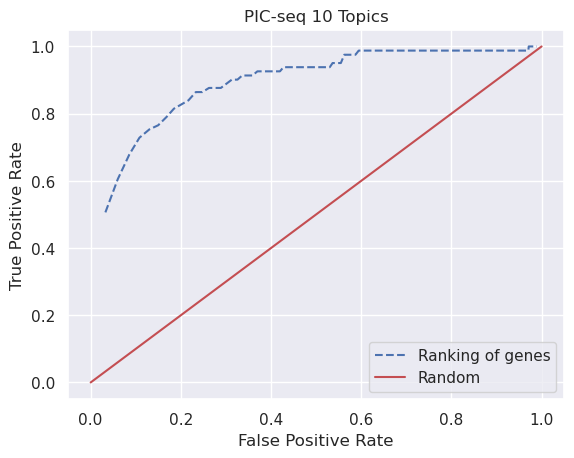

In [537]:
sb.set(font_scale=1)
plt.plot(fpr,tpr,'--',label="Ranking of genes")
plt.plot([0,1],[0,1],'r',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("PIC-seq 10 Topics")
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig("PIC_seq_roc_10.png",dpi=300)

In [251]:
#Heatmap of PICs: 3h, 20h,48h
picsMeta = metaData[metaData["well"].isin(picsCells.columns)]
picsMeta = picsMeta.set_index("well")
cellsCount = pd.DataFrame(scLDA.get_expect_theta(),index=picsCells.columns)

In [252]:
picsCells = picsCells.T.merge(picsMeta,left_index=True,right_index=True)


In [253]:
picsCells['timepoint'] = picsCells['timepoint'].str.rstrip('h') 
picsCells['timepoint'] = pd.to_numeric(picsCells['timepoint'])
picsCells = picsCells.sort_values(by="timepoint",ascending=True)

In [254]:
timepointSort = {3:'orchid',20:'lightblue', 48:'lime'}
newColour2 = [timepointSort[i] for i in picsCells['timepoint'].values]

In [255]:
picsCells = picsCells.drop(picsMeta.columns,axis=1)

In [256]:
dictC = {"3h": "orchid","20h":"lightblue", "48h":"lime"}
colNew = [dictC[picsMeta.loc[i]['timepoint']] for i in picsCells.index]

In [ ]:
newContributions  = pd.DataFrame(scLDA.get_expect_theta(),index = picsCells.index)

In [ ]:
newTopicsGeneMatrix = pd.DataFrame(scLDA.beta_matrix.T,index=all_mono.index)

In [538]:
sb.set(font_scale=9)
topicsNewHM = sb.clustermap(scLDA.get_expect_theta()[:,10:].T,
                  figsize=(80,100),
              row_cluster=False, col_cluster=False,robust=True,cmap='coolwarm',col_colors = [colNew])
blue20h = mpatches.Patch(color="lightblue",label='20h')
orc3h = mpatches.Patch(color="orchid",label='3h')
lime48h = mpatches.Patch(color="lime",label='48h')
legend_TN = [orc3h,blue20h,lime48h]
topicsNewHM.ax_heatmap.set_xticks([])
topicsNewHM.ax_heatmap.set_yticklabels(topicsNewHM.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 100)
topicsNewHM.ax_heatmap.set_xlabel("Cells",fontsize=200)
topicsNewHM.ax_heatmap.set_ylabel("New Topics Ids",fontsize=200)
l2 = topicsNewHM.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.02,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
topicsNewHM.cax.set_position(pos=Bbox(np.array([[0.12,0.2],[0.14,0.7]])))
#plt.savefig("PICS_newTopics.png",bbox_inches='tight',dpi=300)
plt.show()
#plt.savefig("S11.png",bbox_inches='tight',dpi=300)

In [3]:
tops = []
for k in range(10,30):
    tops.append(int_genes[int_genes[3]==k].sort_values([1],ascending=False)[0:10][0].values)

In [529]:
final_genes = [item for sublist in tops for item in sublist]

In [534]:
print (list(set(final_genes)))

['Ubb', 'Vim', 'Myl12b', 'Dusp2', 'Hspa5', 'Serp1', 'Mcm4', 'Npc2', 'Hmgb2', 'Mcm6', 'Ifi27l2a', 'Gzmb', 'Ddt', 'Tpr', 'Il2rb', 'Skp1a', 'Il22', 'Pgk1', 'Prdx1', 'Tax1bp1', 'Hectd1', 'Malat1', 'Kdm6b', 'Klf6', 'Ndufa1', 'Ifih1', 'Gm10288', 'Snx3', 'Itm2b', 'Calr', 'Tyrobp', 'Dusp5', 'Pfkfb3', 'Fcer1g', 'Pmaip1', 'Txndc17', 'Pabpc1', 'Il6', 'Id2', 'Atrx', 'Trbc2', 'Psma7', 'Sub1', 'Akap13', 'mt-Cytb', 'mt-Nd1', 'Gm9800', 'Dut', 'Tbc1d4', 'Gpr183', 'Ifi209', 'Nfkbid', 'Pim1', 'Irf8', 'Ccr7', 'Ptprc', 'Zfand6', 'H2-Aa', 'Oasl1', 'Ldha', 'Gdi2', 'Gnas', 'Atp5e', 'Sqstm1', 'Hsp90ab1', 'Hif1a', 'Cst3', 'Psap', 'Cd74', 'Serbp1', 'Cytip', 'Stk4', 'Il12b', 'Emp3', 'Mir3091', 'Nr4a3', 'AC153498.1', 'Il2ra', 'Slc25a5', 'S100a10', 'Rack1', 'Cd53', 'Ptma', 'Lgals1', 'Tnfrsf18', 'Lgals3', 'Creg1', 'Oasl2', 'Zfp36l1', 'Sdf4', 'AW112010', 'Ccl5', 'AC151846.1', 'Cxcl10', 'Tuba1b', 'Isg15', 'Syngr2', 'Ms4a6c', 'Psmb1', 'Fnbp1', 'Cd69', 'mt-Nd4', 'Ccl22', 'Agfg1', 'Actb', 'Ftl1', 'Tnfrsf4', 'Furin', 'Atp

In [522]:
incl = []
for i in inData:
    if i in final_genes:
        incl.append(i)

In [539]:
print (incl)

['Pcna', 'Ptma', 'Il6', 'Ccl22', 'Il2rb', 'Gzmb', 'Nr4a3', 'Cxcl10', 'Cd40lg', 'Nfkb1', 'S100a4', 'Cd69', 'Cxcr6', 'Icos', 'Tnfrsf18', 'Eif1', 'Snord15b', 'Ccr7', 'Cst3', 'Irf7', 'Isg15', 'Top2a', 'Npm1', 'Tcf7', 'Lgals1', 'Mcm4', 'Hopx', 'Ikzf2', 'Tigit', 'Tnfrsf4', 'Foxp3', 'Tnfrsf9', 'Il12b', 'Il22', 'Cd83', 'Irf4', 'Ifit1', 'Stat1', 'Trac', 'Dut', 'Tnf']


In [524]:
genesToPlot = ['Ptma','Pcna','Trac','Dut','Il6','Ccl22','Il2rb','Gzmb','Nr4a3','Cxcl10','Cd40lg','Nfkb1',
 'S100a4','Cd69','Cxcr6','Icos','Tnfrsf18','Tnfrsf9','Tnfrsf4','Eif1','Snord15b','Ccr7','Cst3','Irf7','Isg15','Top2a','Npm1',
 'Tcf7','Lgals1','Mcm4','Hopx','Ikzf2','Tigit','Foxp3','Il12b','Il22','Cd83','Irf4','Ifit1','Stat1','Tnf']

In [540]:
sb.set(font_scale=9)
blue20h = mpatches.Patch(color="lightblue",label='20h')
orc3h = mpatches.Patch(color="orchid",label='3h')
lime48h = mpatches.Patch(color="lime",label='48h')
legend_TN = [orc3h,blue20h,lime48h]
heatmap1 = sb.clustermap(np.log1p(picsCells[genesToPlot].T),
                  figsize=(100,80),
              row_cluster=False, col_cluster=False,robust=True,cmap='coolwarm',col_colors = [newColour2])

heatmap1.ax_heatmap.set_xticks([])
heatmap1.ax_heatmap.set_yticklabels(heatmap1.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmap1.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmap1.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmap1.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.09,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")


heatmap1.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()

#plt.savefig("Fig8.png",bbox_inches='tight',dpi=300)
